In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anime-pictures/images/35715_2011.jpg
/kaggle/input/anime-pictures/images/48610_2014.jpg
/kaggle/input/anime-pictures/images/34719_2011.jpg
/kaggle/input/anime-pictures/images/40266_2012.jpg
/kaggle/input/anime-pictures/images/4199_2002.jpg
/kaggle/input/anime-pictures/images/40739_2013.jpg
/kaggle/input/anime-pictures/images/42515_2013.jpg
/kaggle/input/anime-pictures/images/52482_2015.jpg
/kaggle/input/anime-pictures/images/46555_2014.jpg
/kaggle/input/anime-pictures/images/11579_2005.jpg
/kaggle/input/anime-pictures/images/36943_2012.jpg
/kaggle/input/anime-pictures/images/9787_2004.jpg
/kaggle/input/anime-pictures/images/3388_2002.jpg
/kaggle/input/anime-pictures/images/8393_2004.jpg
/kaggle/input/anime-pictures/images/30352_2010.jpg
/kaggle/input/anime-pictures/images/10908_2005.jpg
/kaggle/input/anime-pictures/images/22363_2008.jpg
/kaggle/input/anime-pictures/images/51151_2015.jpg
/kaggle/input/anime-pictures/images/59491_2018.jpg
/kaggle/input/anime-pictures/images

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd 
import os

In [3]:
# Here, we store the directory path
DATA_DIR='/kaggle/input/anime-pictures'

In [4]:
# count number of images
lst = os.listdir("/kaggle/input/anime-pictures/images") # your directory path
number_files = len(lst)
print(number_files)

63565


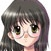

(51, 51, 3)


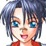

(46, 46, 3)


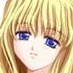

(73, 73, 3)


In [5]:
# showing some examples with their size
from IPython.display import Image, display
import cv2
image = cv2.imread("/kaggle/input/anime-pictures/images/10006_2004.jpg")
display(Image(filename="/kaggle/input/anime-pictures/images/10006_2004.jpg"))
print(image.shape)
image = cv2.imread("/kaggle/input/anime-pictures/images/10021_2004.jpg")
display(Image(filename="/kaggle/input/anime-pictures/images/10021_2004.jpg"))
print(image.shape)
image = cv2.imread("/kaggle/input/anime-pictures/images/10049_2004.jpg")
display(Image(filename="/kaggle/input/anime-pictures/images/10049_2004.jpg"))
print(image.shape)

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
# Using the ImageFolder class from torchvision with transform.
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
def denorm(img_tensors):#### In order to convert the tensors into the images back we need to denormalize the tensors.Creating helper functions to denormalize the image tensors and display some sample images from a training batch.
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

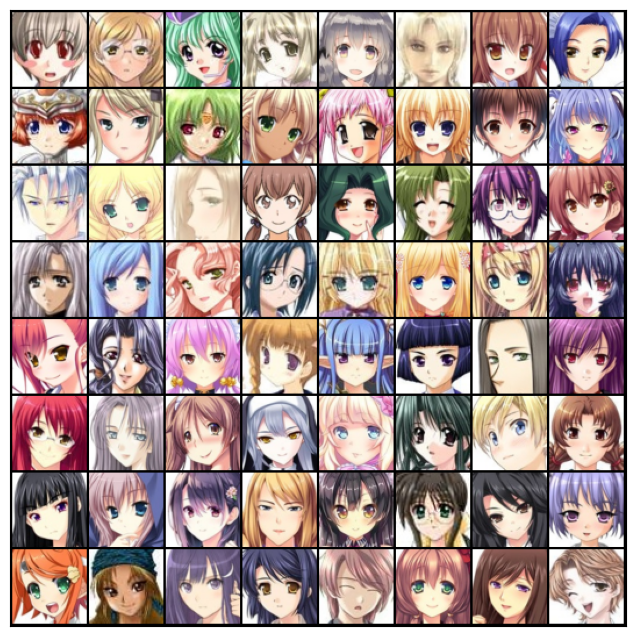

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    #output_size = (input_size - kernel_size + 2 * padding) / stride + 1
    #output_size = (64 - 4 + 2 * 1) / 2 + 1 = 32
    
    
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


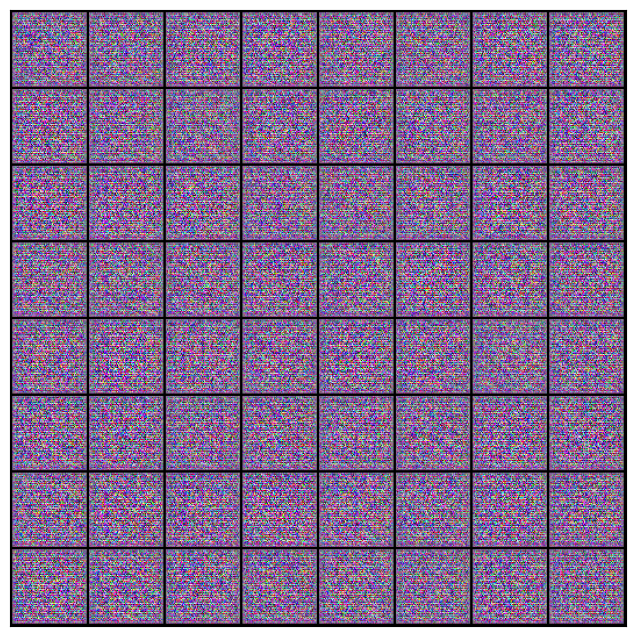

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    # Extract the numerical value of the loss tensor
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


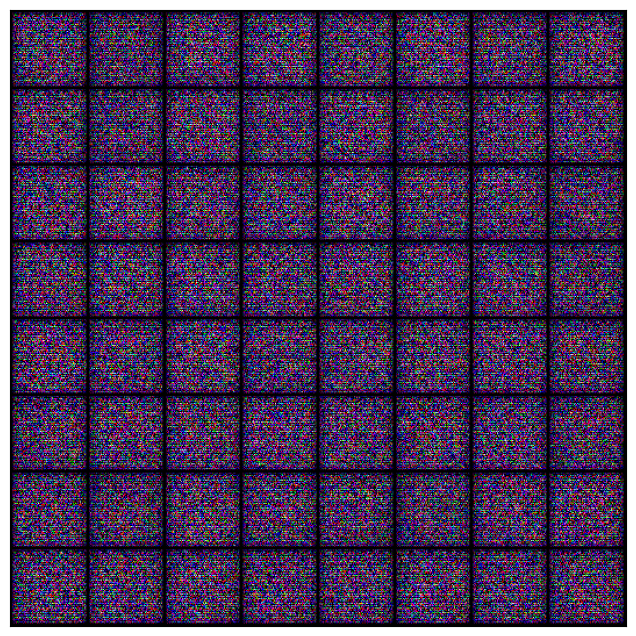

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [29]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [38]:
lr = 0.0002
epochs = 30

In [39]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 8.1460, loss_d: 0.0259, real_score: 0.9826, fake_score: 0.0052
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 16.6613, loss_d: 0.0220, real_score: 0.9992, fake_score: 0.0181
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 12.4985, loss_d: 0.0293, real_score: 0.9753, fake_score: 0.0018
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 6.3049, loss_d: 0.0179, real_score: 0.9873, fake_score: 0.0042
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 5.3758, loss_d: 0.0149, real_score: 0.9990, fake_score: 0.0136
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 33.6148, loss_d: 0.0006, real_score: 0.9994, fake_score: 0.0000
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 31.4100, loss_d: 0.0375, real_score: 0.9848, fake_score: 0.0024
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 7.7750, loss_d: 0.0107, real_score: 0.9923, fake_score: 0.0026
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 42.6036, loss_d: 0.0102, real_score: 0.9905, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 6.2657, loss_d: 0.0360, real_score: 0.9747, fake_score: 0.0009
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 4.0087, loss_d: 0.0258, real_score: 0.9864, fake_score: 0.0093
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 12.9606, loss_d: 0.0230, real_score: 0.9996, fake_score: 0.0214
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 8.5051, loss_d: 0.0276, real_score: 0.9876, fake_score: 0.0138
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 6.4226, loss_d: 0.0101, real_score: 0.9985, fake_score: 0.0085
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 15.0863, loss_d: 0.0119, real_score: 0.9932, fake_score: 0.0048
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 7.6670, loss_d: 0.0263, real_score: 0.9787, fake_score: 0.0018
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 11.0155, loss_d: 0.0628, real_score: 0.9989, fake_score: 0.0588
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 48.2718, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 47.0512, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 21.5599, loss_d: 0.1423, real_score: 0.9392, fake_score: 0.0000
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 5.8744, loss_d: 0.0566, real_score: 0.9772, fake_score: 0.0195
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 7.2507, loss_d: 0.0215, real_score: 0.9824, fake_score: 0.0005
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 9.3358, loss_d: 0.6892, real_score: 0.6850, fake_score: 0.0000
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 5.8776, loss_d: 0.0535, real_score: 1.0000, fake_score: 0.0477
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 7.0931, loss_d: 0.0154, real_score: 0.9939, fake_score: 0.0088
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 8.5966, loss_d: 0.1100, real_score: 0.9722, fake_score: 0.0075
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 8.5110, loss_d: 0.0471, real_score: 0.9980, fake_score: 0.0421
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 5.5455, loss_d: 0.0158, real_score: 0.9962, fake_score: 0.0117
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 7.7597, loss_d: 0.0048, real_score: 0.9990, fake_score: 0.0037
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 29.3176, loss_d: 0.0172, real_score: 0.9996, fake_score: 0.0160
Saving generated-images-0030.png


In [40]:
losses_g, losses_d, real_scores, fake_scores = history

In [41]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

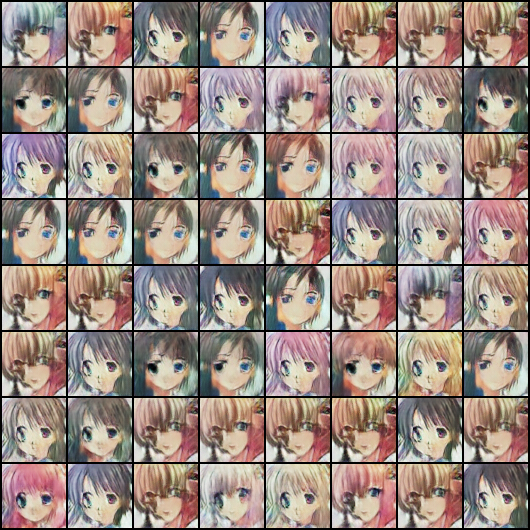

In [42]:
Image('./generated/generated-images-0001.png')

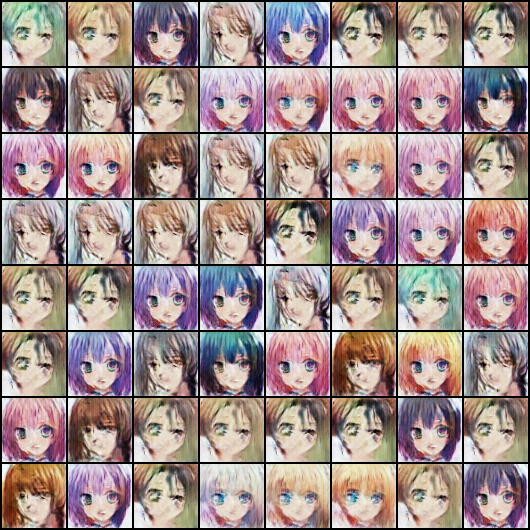

In [43]:
Image('./generated/generated-images-0020.png')

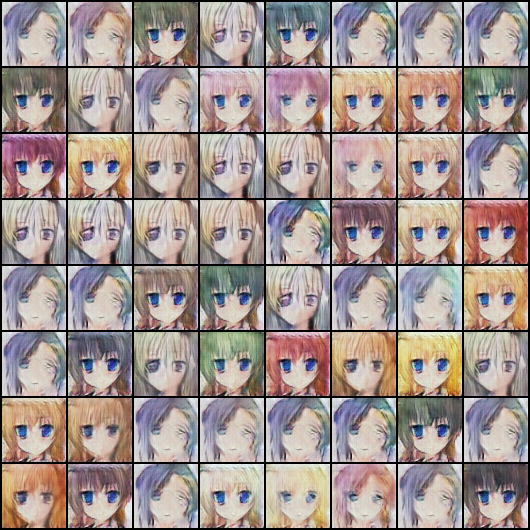

In [44]:
Image('./generated/generated-images-0025.png')

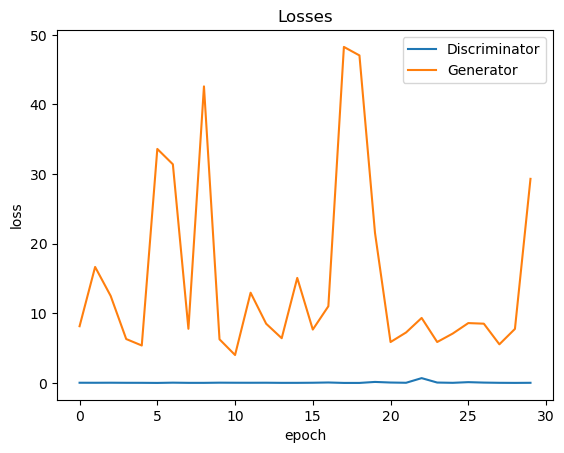

In [45]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

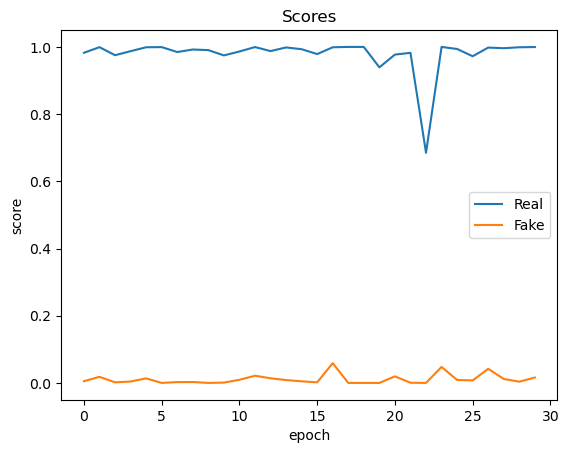

In [46]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');